<a href="https://colab.research.google.com/github/faithrts/COMP-551/blob/GaryBranch/Copy_of_A1_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [480]:
### importing libraries and setting the random seed

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import math
import bisect
from scipy.stats import zscore
from scipy.io import arff
from importlib import reload

from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as skl_train_test_split

np.random.seed(1234)

# Data Handling

## Importing

In [481]:
### importing the files from the web to google colab

# hepatitis.data
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data

# messidor_features.arff
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff

--2022-10-09 00:02:20--  http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7545 (7.4K) [application/x-httpd-php]
Saving to: ‘hepatitis.data.5’

hepatitis.data.5    100%[===================>]   7.37K  --.-KB/s    in 0s      

2022-10-09 00:02:20 (668 MB/s) - ‘hepatitis.data.5’ saved [7545/7545]

--2022-10-09 00:02:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117224 (114K) [application/x-httpd-php]
Saving to: ‘messidor_features.arff.5’

messidor_features.a 100%[===================>] 114.4

## Preprocessing

### Helper functions

In [482]:
# replaces instances of '?' with the column's mean or mode
def imputation(df, bool_col, non_bool_col):
  copy_df = df.copy()

  # saves a copy of the dataframe without rows that include '?' values
  intact_rows = copy_df[~copy_df.eq('?').any(axis=1)].astype('float')

  # iterates through columns with boolean values
  for col in bool_col:

    # replaces instances of 1.0 and 2.0 with the boolean integers 0 and 1
    intact_rows[col] = intact_rows[col].replace({1.0:0, 2.0:1})
    # calculates the mode of the current column (ignores '?')
    mode = int(intact_rows[col].mode()[0])

    # in the original dataframe, replaces each '?' with the column's mode
    copy_df[col] = copy_df[col].replace({'?': mode}).astype('int64')
    # in the original dataframe, replaces 1.0 and 2.0 with boolean ints 0 and 1
    copy_df[col] = copy_df[col].replace({1.0:0, 2.0:1})

  # iterates through columns with non-boolean values
  for col in non_bool_col:
    # calculates the mean of the current column (ignores '?')
    mean = intact_rows[col].mean()
    # in the original dataframe, replaces each '?' with the column's mean
    copy_df[col] = copy_df[col].replace({'?': mean}).astype('float')
    
  return copy_df

In [483]:
### computes zcore to remove outlier data
def remove_outliers(df):
  abs_z_scores = np.abs(df.apply(zscore))

  # a boolean array that returns True at index i if the row
  # i in df does not contain any values with a zscore greater
  # than 3
  instance_bool_arr = (abs_z_scores < 3).all(axis = 1)
  return df[instance_bool_arr]

In [484]:
# normalizes an input array
def normalize_array(arr):
  normalized_array = []

  for i in arr:
    new_val = (i - min(arr)) / (max(arr) - min(arr))
    normalized_array.append(new_val)

  return normalized_array

# normalizes columns in input dataframe df; 
# assumes last column is the target labels
def normalize_df(df):
  normalized_df = df.copy()

  for col in normalized_df.iloc[:, :-1]:
    normalized_col = normalize_array(df[col])
    normalized_df[col] = normalized_col

  return normalized_df

In [485]:
# standardizes columns in input dataframe df;
# assumes last column is the target labels
def standardize_df(df):
  standardized_df = df.copy()

  # iterates through each column, excluding the last column
  for col in standardized_df.iloc[:, :-1]:

    # calculates mean value and standard deviation of column
    mean_val = standardized_df[col].mean()
    standard_dev = standardized_df[col].std()

    # standardizes the values in the current column
    standardized_df[col] = (standardized_df[col] - mean_val) / standard_dev

  return standardized_df

In [486]:
# function to split the data;
# assumes the last column of the df is the target label
# and percentage_train is an integer out of 100
def train_test_split(df, percentage_train = 66):
  # makes a copy of the input df
  copy_df = df.copy()

  # shuffling the order of rows in the input dataframe
  copy_df = copy_df.sample(frac = 1, random_state = 1)

  # splits the input dataframe into arrays of instances and labels
  x, y = copy_df.iloc[:, :-1].to_numpy(), copy_df.iloc[:, -1].to_numpy()

  # the number of data points
  instance_count = x.shape[0]

  # the number of instances to be used in the training data
  train_count = int(instance_count * (percentage_train / 100))

  # splitting the data into training data and labels,
  # and testing data and labels
  x_train, y_train = x[:train_count], y[:train_count]
  x_test, y_test = x[train_count:], y[train_count:]

  return x_train, x_test, y_train, y_test

In [487]:
# function to split the data based on input x and y
# and percentage_train is an integer out of 100
def train_test_split2(x, y, percentage_train = 66):

  temp_df = pd.DataFrame(x)
  temp_df['CLASS'] = y

  x_train, x_test, y_train, y_test = train_test_split(temp_df, percentage_train)

  return x_train, x_test, y_train, y_test

In [488]:
# assumes the first column is target labels
def RF_find_features2(df):
  # splitting the data in the input dataframe df
  x_train, x_test, y_train, y_test = train_test_split(df)

  # define the model
  model = RandomForestRegressor()

  # fit the model
  model.fit(x_train, y_train)

  # the value at index i is the feature importance of the
  # feature at column i in the dataframe
  importance_arr = model.feature_importances_

  # summarize feature importance
  for i in range(len(importance_arr)):
      print('Feature: %s, Score: %.5f' % (list(df.columns)[i], importance_arr[i]))

  return importance_arr

In [489]:
# random forest for feature importance on a regression problem;
# assumes the first column is target labels
def RF_find_features(df):
  # splitting the data in the input dataframe df
  x_train, x_test, y_train, y_test = train_test_split(df)

  # define the model
  model = RandomForestRegressor()

  # fit the model
  model.fit(x_train, y_train)

  # the value at index i is the feature importance of the
  # feature at column i in the dataframe
  importance_arr = model.feature_importances_

  # summarize feature importance
  for i in range(len(importance_arr)):
      print('Feature: %s, Score: %.5f' % (list(df.columns)[i], importance_arr[i]))

  return importance_arr

In [490]:
# random forest for feature importance on a regression problem
def RF_find_features_XY(x_train, y_train, df):
  # splitting the data in the input dataframe df

  # define the model
  model = RandomForestRegressor()

  # fit the model
  model.fit(x_train, y_train)

  # the value at index i is the feature importance of the
  # feature at column i in the dataframe
  importance_arr = model.feature_importances_

  # summarize feature importance
  for i in range(len(importance_arr)):
      print('Feature: %s, Score: %.5f' % (list(df.columns)[i], importance_arr[i]))

  return importance_arr

In [491]:
# prints the top 2 features in an importance array
def top_2_features(importance_arr, df):
  top_feat_value = max(importance_arr)
  top_feat_index = importance_arr.tolist().index(top_feat_value)

  second_feat_value = np.max([val for index, val in enumerate(importance_arr) if index != top_feat_index])
  second_feat_index = importance_arr.tolist().index(second_feat_value)

  print("The most important feature is " + list(df.columns)[top_feat_index])
  print("The second most important feature is " + list(df.columns)[second_feat_index])

#### Graphing functions

In [492]:
# counts items in a given range
def count_in_ranges(item_arr, range_arr, bins = 10):
  count_arr = np.zeros(len(range_arr))

  for item in item_arr:
    pos = bisect.bisect_left(range_arr, item)
    count_arr[pos] += 1

  return count_arr

# creates histograms for each column in input dataframe df and array of columns
# column_arr
def create_histograms(df, column_arr = 0, n_cols = 3):
  # if no array of column names given, creates histograms for all columns
  if column_arr == 0:
    column_arr = list(df)

  # the number of rows
  n_rows = math.ceil(len(column_arr)/n_cols)

  # setting up a figure
  fig = plt.figure(figsize = (15, 9), tight_layout = True)

  # setting up space for graphs
  gs = gridspec.GridSpec(n_rows, n_cols)

  # setting current column and row numbers
  cur_col, cur_row = 0, 0

  # iterates through each column name
  for col in column_arr:
    min = math.floor(df[col].min())
    max = math.ceil(df[col].max())
    mean = df[col].mean()
    
    range_arr = np.linspace(min, max + 1, 100)
    count_arr = count_in_ranges(df[col].to_numpy(), range_arr)

    if cur_col == n_cols:
      cur_col = 0
      cur_row += 1

    # plots histogram
    ax = fig.add_subplot(gs[cur_row, cur_col])
    ax.autoscale(True)
    ax.bar(count_arr, range_arr)
    ax.set_title(col.upper())
    ax.set_xlabel("Occurrence count")
    ax.set_ylabel("Value")
    ax.axhline(y = mean, color = 'r', linestyle = '-', label = "Mean = " + str(round(mean, 2)))
    
    cur_col += 1
  plt.show()

In [493]:
# plots feature importance
def plot_feature_importance(importance_arr):
  mean = importance_arr.mean()

  plt.bar([x for x in range(len(importance_arr))], importance_arr)
  plt.title("Feature importance")
  plt.xlabel("Feature index in data")
  plt.ylabel("Score")
  plt.axhline(y = mean, color = 'r', linestyle = '-', label = "Mean = " + str(round(mean, 2)))
  plt.legend(loc = "upper right")
  plt.show()

In [494]:
# plots the distributions of boolean feature values
def plot_bool_distributions(column_arr, df, n_cols = 3):
  # the number of rows
  n_rows = math.ceil(len(column_arr)/n_cols)

  # setting up a figure
  fig = plt.figure(figsize = (15, 9), tight_layout = True)

  # setting up space for graphs
  gs = gridspec.GridSpec(n_rows, n_cols)

  # setting current column and row numbers
  cur_col, cur_row = 0, 0
  
  for col in column_arr:
    x_arr = ['True', 'False']
    y_arr = np.bincount(df[col].to_numpy())

    if cur_col == n_cols:
      cur_col = 0
      cur_row += 1

    # plots histogram
    ax = fig.add_subplot(gs[cur_row, cur_col])
    ax.autoscale(True)
    ax.bar(x_arr, y_arr)
    ax.set_title(col.upper())
    ax.set_xlabel("Value")
    ax.set_ylabel("Instance count")

    bar_num = 0

    for bar in ax.patches:
      percentage = round((y_arr[bar_num]/y_arr.sum()), 2) * 100

      w = bar.get_width()
      h = bar.get_height()
      x, y = bar.get_xy()
      plt.text(x + w/2, y + h*1.01, str(percentage) + '%', ha = 'center')
      
      bar_num += 1

    cur_col += 1

  plt.show()

### Loading and cleaning hepatitis.data

In [495]:
### creating the dataframe for hepatitis.data

# creates a dataframe from the .data file
hep_df = pd.read_csv("hepatitis.data", sep=",", header=None)

# the column names
hep_cols = ['CLASS', 'AGE', 'SEX', 'STEROID','ANTIVIRALS', 'FATIGUE',
            'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM',
            'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES',
            'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN',
            'PROTIME', 'HISTOLOGY']

# adds the column names to the dataframe
hep_df.columns = hep_cols

In [496]:
### creating lists to separate the names of columns containing
### boolean values vs the ones containing continuous values

bool_col = ['CLASS', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE',
            'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM',
            'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES',
            'HISTOLOGY']

non_bool_col = ['AGE', 'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']

In [497]:
### cleaning hepatitis dataframe

# moves the target "CLASS" column to the end of the dataframe
class_col = hep_df.pop('CLASS')
hep_df['CLASS'] = class_col

# saves a copy of the dataframe cleaned through imputation
hep_imp_df = imputation(hep_df, bool_col, non_bool_col)

# removes all rows with ?
hep_df = hep_df[~hep_df.eq('?').any(axis=1)].astype('float')

# maps all 1.0 values to 0 and all 2.0 values to 1
for col in bool_col:
  hep_df[col] = hep_df[col].replace({1.0:0, 2.0:1}).astype('int')

In [498]:
hep_imp_df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
0,30.0,1,0,1,1,1,1,0,1,1,1,1,1,1.0,85.0000,18.0,4.0,62.5125,0,1
1,50.0,0,0,1,0,1,1,0,1,1,1,1,1,0.9,135.0000,42.0,3.5,62.5125,0,1
2,78.0,0,1,1,0,1,1,1,1,1,1,1,1,0.7,96.0000,32.0,4.0,62.5125,0,1
3,31.0,0,0,0,1,1,1,1,1,1,1,1,1,0.7,46.0000,52.0,4.0,80.0000,0,1
4,34.0,0,1,1,1,1,1,1,1,1,1,1,1,1.0,102.9125,200.0,4.0,62.5125,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,46.0,0,1,1,0,0,0,1,1,1,0,0,0,7.6,102.9125,242.0,3.3,50.0000,1,0
151,44.0,0,1,1,0,1,1,1,0,1,1,1,1,0.9,126.0000,142.0,4.3,62.5125,1,1
152,61.0,0,0,1,0,0,1,0,0,1,0,1,1,0.8,75.0000,20.0,4.1,62.5125,1,1
153,53.0,1,0,1,0,1,1,1,1,0,0,1,0,1.5,81.0000,19.0,4.1,48.0000,1,1


In [499]:
hep_df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
5,34.0,0,1,1,1,1,1,1,1,1,1,1,1,0.9,95.0,28.0,4.0,75.0,0,1
10,39.0,0,0,0,1,1,1,0,0,1,1,1,1,1.3,78.0,30.0,4.4,85.0,0,1
11,32.0,0,1,0,0,1,1,1,0,1,0,1,1,1.0,59.0,249.0,3.7,54.0,0,1
12,41.0,0,1,0,0,1,1,1,0,1,1,1,1,0.9,81.0,60.0,3.9,52.0,0,1
13,30.0,0,1,1,0,1,1,1,0,1,1,1,1,2.2,57.0,144.0,4.9,78.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,45.0,0,1,0,1,1,1,1,1,1,1,1,1,1.3,85.0,44.0,4.2,85.0,1,1
143,49.0,0,0,1,0,0,1,1,1,0,0,1,1,1.4,85.0,70.0,3.5,35.0,1,0
145,31.0,0,0,1,0,1,1,1,1,1,1,1,1,1.2,75.0,173.0,4.2,54.0,1,1
153,53.0,1,0,1,0,1,1,1,1,0,0,1,0,1.5,81.0,19.0,4.1,48.0,1,1


In [500]:
# uses zscore to remove outliers 
# (rows with values above 3 standard deviations beyond the respective column means)
hep_df = remove_outliers(hep_df)

In [501]:
# the data without the outliers
hep_df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
5,34.0,0,1,1,1,1,1,1,1,1,1,1,1,0.9,95.0,28.0,4.0,75.0,0,1
10,39.0,0,0,0,1,1,1,0,0,1,1,1,1,1.3,78.0,30.0,4.4,85.0,0,1
11,32.0,0,1,0,0,1,1,1,0,1,0,1,1,1.0,59.0,249.0,3.7,54.0,0,1
12,41.0,0,1,0,0,1,1,1,0,1,1,1,1,0.9,81.0,60.0,3.9,52.0,0,1
13,30.0,0,1,1,0,1,1,1,0,1,1,1,1,2.2,57.0,144.0,4.9,78.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,45.0,0,1,0,1,1,1,1,1,1,1,1,1,1.3,85.0,44.0,4.2,85.0,1,1
143,49.0,0,0,1,0,0,1,1,1,0,0,1,1,1.4,85.0,70.0,3.5,35.0,1,0
145,31.0,0,0,1,0,1,1,1,1,1,1,1,1,1.2,75.0,173.0,4.2,54.0,1,1
153,53.0,1,0,1,0,1,1,1,1,0,0,1,0,1.5,81.0,19.0,4.1,48.0,1,1


In [502]:
### saving train/test splits for different versions of hepatitis data

# for the whole hepatitis dataframe
x_train_hep, x_test_hep, y_train_hep, y_test_hep = train_test_split(hep_df)

# for the hepatitis dataframe cleaned through imputation
x_train_hep_imp, x_test_hep_imp, y_train_hep_imp, y_test_hep_imp = train_test_split(hep_imp_df)

### Analysis of Hepatitis data

In [503]:
### finding the most correlated features with CLASS column (target)

# creates correlation dataframe
correlation_df = hep_df.corr()

# isolates for the CLASS column of the correlation dataframe and removes
# the CLASS row
class_correlation = (correlation_df).iloc[:-1, -1:]

# finds the 3 largest values (the 3 features most positively 
# correlated with CLASS)
pos_correlation = class_correlation.nlargest(3, 'CLASS')

# show the 3 features most positively correlated with target labels
pos_correlation.head()

,CLASS
ALBUMIN,0.393190
ASCITES,0.367521
PROTIME,0.328634


In [504]:
# finds the 3 smallest values (the 3 features most negatively
# correlated with CLASS)
neg_correlation = class_correlation.nsmallest(3, 'CLASS')

# show the 3 features most negatively correlated with target labels
neg_correlation.head()

,CLASS
HISTOLOGY,-0.463524
LIVER BIG,-0.171780
AGE,-0.165716


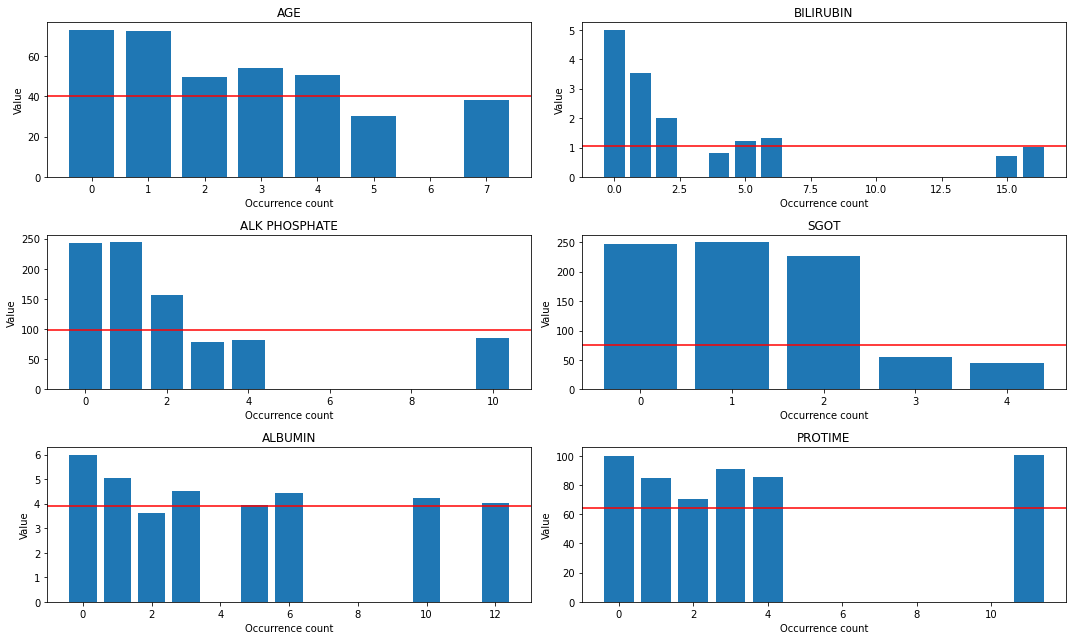

In [505]:
# outputs histograms (but with occurrence count along the x-axis)
# of the non-boolean columns
create_histograms(hep_df, non_bool_col, 2)

Feature: AGE, Score: 0.06765
Feature: SEX, Score: 0.00832
Feature: STEROID, Score: 0.00557
Feature: ANTIVIRALS, Score: 0.00000
Feature: FATIGUE, Score: 0.00111
Feature: MALAISE, Score: 0.01034
Feature: ANOREXIA, Score: 0.01889
Feature: LIVER BIG, Score: 0.00328
Feature: LIVER FIRM, Score: 0.00000
Feature: SPLEEN PALPABLE, Score: 0.01275
Feature: SPIDERS, Score: 0.00502
Feature: ASCITES, Score: 0.01745
Feature: VARICES, Score: 0.01640
Feature: BILIRUBIN, Score: 0.13715
Feature: ALK PHOSPHATE, Score: 0.11083
Feature: SGOT, Score: 0.04029
Feature: ALBUMIN, Score: 0.10264
Feature: PROTIME, Score: 0.35439
Feature: HISTOLOGY, Score: 0.08791


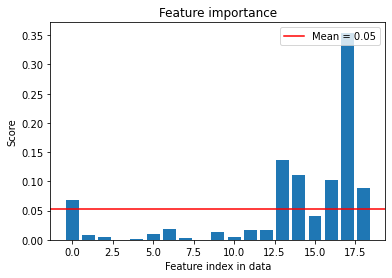

In [506]:
### using random forest to determine the relative feature importance

hep_importance_arr = RF_find_features(hep_df)

# plots the feature importance
plot_feature_importance(hep_importance_arr)

In [507]:
### finding the top 2 most important features to confirm values in correlation dataframe

top_2_features(hep_importance_arr, hep_df)

The most important feature is PROTIME
The second most important feature is BILIRUBIN


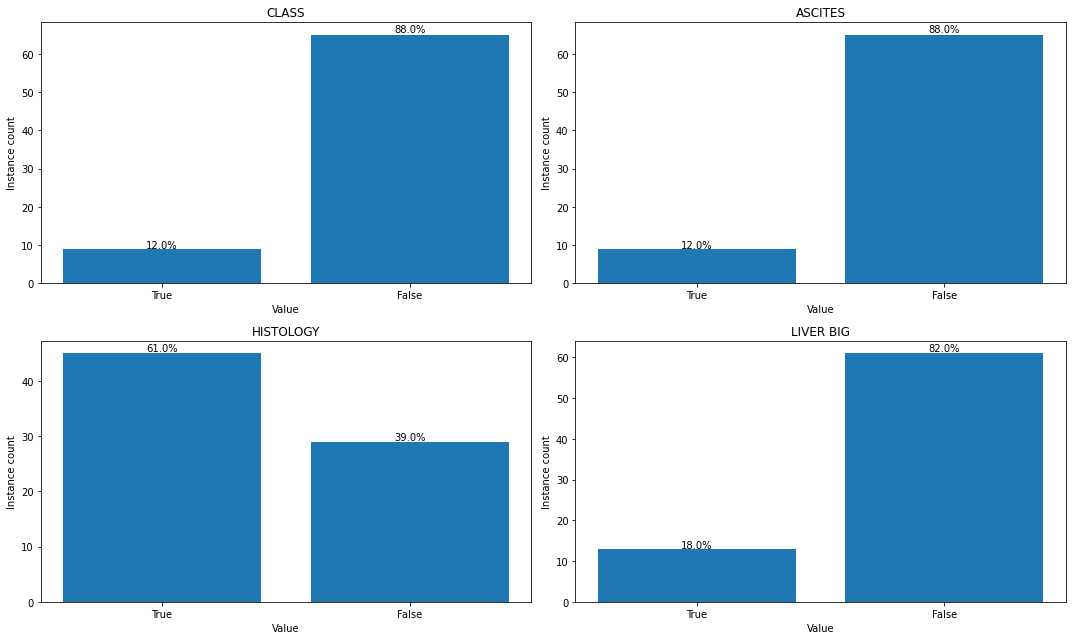

In [508]:
### analysis of boolean distributions for CLASS, ASCITES, HISTOLOGY, LIVER BIG

bool_cols_of_interest = ['CLASS', 'ASCITES', 'HISTOLOGY', 'LIVER BIG']

# plotting a bar graph for each boolean column of interest
plot_bool_distributions(bool_cols_of_interest, hep_df, 2)

### Loading and cleaning messidor.arff

In [509]:
### creating the dataframe for messidor_features.arff

# loads in the arff data
mess_data = arff.loadarff('messidor_features.arff')
# creates a dataframe from the .arff file
mess_df = pd.DataFrame(mess_data[0])

# the column names
mess_cols = ['QUALITY ASSESSMENT', 'PRE-SCREENING', 'MA DETECTION CL 0.5',
            'MA DETECTION CL 0.58','MA DETECTION CL 0.66', 'MA DETECTION CL 0.75',
            'MA DETECTION CL 0.83','MA DETECTION CL 0.91', 'MA DETECTION CL 1.0',
            'EXUDATES CL 0.5', 'EXUDATES CL 0.58','EXUDATES CL 0.66',
            'EXUDATES CL 0.75', 'EXUDATES CL 0.83','EXUDATES CL 0.91',
            'EXUDATES CL 1.0', 'MACULA-OPTIC DISC DISTANCE', 'OPTIC DISC DIAMATER', 
            'AM/FM CLASSIFICATION', 'CLASS']

# adds the column names to the dataframe
mess_df.columns = mess_cols

In [510]:
### cleaning the data in mess_df; there's no missing data so no imputation

# resaving the boolean values in the Class column from objects to ints
mess_df['CLASS'] = mess_df['CLASS'].map({b'0':0, b'1':1})

# columns with boolean values
mess_bool_cols = ['QUALITY ASSESSMENT', 'PRE-SCREENING', 'AM/FM CLASSIFICATION', 'CLASS']

# ensures the columns with boolean values save as integers
for col in mess_bool_cols:
  mess_df[col] = mess_df[col].astype('int64')

In [511]:
mess_df

,QUALITY ASSESSMENT,PRE-SCREENING,MA DETECTION CL 0.5,MA DETECTION CL 0.58,MA DETECTION CL 0.66,MA DETECTION CL 0.75,MA DETECTION CL 0.83,MA DETECTION CL 0.91,MA DETECTION CL 1.0,EXUDATES CL 0.5,EXUDATES CL 0.58,EXUDATES CL 0.66,EXUDATES CL 0.75,EXUDATES CL 0.83,EXUDATES CL 0.91,EXUDATES CL 1.0,MACULA-OPTIC DISC DISTANCE,OPTIC DISC DIAMATER,AM/FM CLASSIFICATION,CLASS
0,1,1,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,1,1,34.0,34.0,34.0,33.0,31.0,24.0,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0,0
1147,1,1,49.0,49.0,49.0,49.0,45.0,37.0,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0,0
1148,1,0,49.0,48.0,48.0,45.0,43.0,33.0,30.461898,13.966980,1.763305,0.137858,0.011221,0.000000,0.000000,0.000000,0.560632,0.129843,0,0
1149,1,1,39.0,36.0,29.0,23.0,13.0,7.0,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1,1


In [512]:
# uses zscore to remove outliers 
# (rows with values above 3 standard deviations beyond the respective column means)
mess_df = remove_outliers(mess_df)

In [513]:
# the data without the outliers
mess_df

,QUALITY ASSESSMENT,PRE-SCREENING,MA DETECTION CL 0.5,MA DETECTION CL 0.58,MA DETECTION CL 0.66,MA DETECTION CL 0.75,MA DETECTION CL 0.83,MA DETECTION CL 0.91,MA DETECTION CL 1.0,EXUDATES CL 0.5,EXUDATES CL 0.58,EXUDATES CL 0.66,EXUDATES CL 0.75,EXUDATES CL 0.83,EXUDATES CL 0.91,EXUDATES CL 1.0,MACULA-OPTIC DISC DISTANCE,OPTIC DISC DIAMATER,AM/FM CLASSIFICATION,CLASS
0,1,1,22.0,22.0,22.0,19.0,18.0,14.0,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24.0,24.0,22.0,18.0,16.0,13.0,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62.0,60.0,59.0,54.0,47.0,33.0,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55.0,53.0,53.0,50.0,43.0,31.0,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44.0,44.0,44.0,41.0,39.0,27.0,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,1,1,35.0,34.0,33.0,33.0,33.0,26.0,2.579859,0.001552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.537551,0.124181,0,0
1146,1,1,34.0,34.0,34.0,33.0,31.0,24.0,6.071765,0.937472,0.031145,0.003115,0.000000,0.000000,0.000000,0.000000,0.537470,0.116795,0,0
1147,1,1,49.0,49.0,49.0,49.0,45.0,37.0,63.197145,27.377668,8.067688,0.979548,0.001552,0.000000,0.000000,0.000000,0.516733,0.124190,0,0
1149,1,1,39.0,36.0,29.0,23.0,13.0,7.0,40.525739,12.604947,4.740919,1.077570,0.563518,0.326860,0.239568,0.174584,0.485972,0.106690,1,1


In [514]:
# creating the training and testing data and labels for the messidor dataframe
x_train_mess, x_test_mess, y_train_mess, y_test_mess = train_test_split(mess_df)

### Analysis of Messidor Features

In [515]:
### finding the most correlated features with Class column (target)

# creates correlation dataframe
correlation_df = mess_df.corr()

# removes the first row of the correlation dataframe
class_correlation = (correlation_df).iloc[:-1, -1:]

# finds the 3 largest values (the 3 features most positively 
# correlated with CLASS)
pos_correlation = class_correlation.nlargest(3, 'CLASS')

# show the 3 features most positively correlated with target labels
pos_correlation.head()

,CLASS
MA DETECTION CL 0.5,0.282618
MA DETECTION CL 0.58,0.254831
MA DETECTION CL 0.66,0.224684


In [516]:
# finds the 3 smallest values (the 3 features most negatively
# correlated with CLASS)
neg_correlation = class_correlation.nsmallest(3, 'CLASS')

# show the 3 features most negatively correlated with target labels
neg_correlation.head()

,CLASS
EXUDATES CL 0.5,-0.064864
EXUDATES CL 0.58,-0.030217
AM/FM CLASSIFICATION,-0.023560


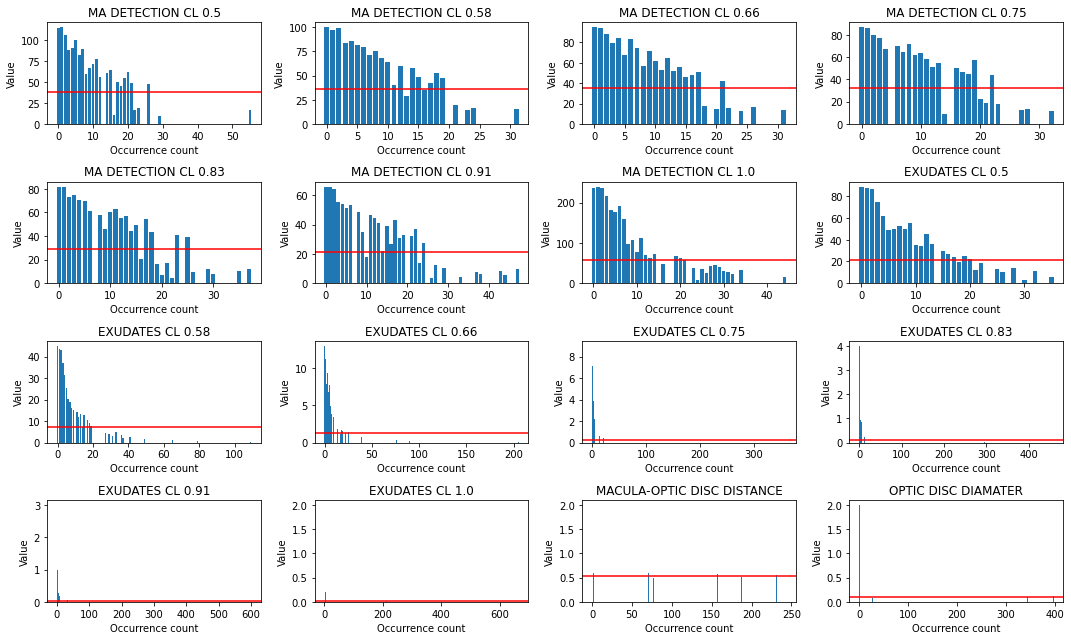

In [517]:
### creating histograms for each non-boolean valued column

create_histograms(mess_df, list(mess_df)[2:18], 4)

Feature: QUALITY ASSESSMENT, Score: 0.00000
Feature: PRE-SCREENING, Score: 0.00000
Feature: MA DETECTION CL 0.5, Score: 0.13718
Feature: MA DETECTION CL 0.58, Score: 0.02393
Feature: MA DETECTION CL 0.66, Score: 0.02420
Feature: MA DETECTION CL 0.75, Score: 0.03096
Feature: MA DETECTION CL 0.83, Score: 0.03345
Feature: MA DETECTION CL 0.91, Score: 0.04525
Feature: MA DETECTION CL 1.0, Score: 0.09298
Feature: EXUDATES CL 0.5, Score: 0.08353
Feature: EXUDATES CL 0.58, Score: 0.07630
Feature: EXUDATES CL 0.66, Score: 0.08076
Feature: EXUDATES CL 0.75, Score: 0.04197
Feature: EXUDATES CL 0.83, Score: 0.03122
Feature: EXUDATES CL 0.91, Score: 0.08038
Feature: EXUDATES CL 1.0, Score: 0.02757
Feature: MACULA-OPTIC DISC DISTANCE, Score: 0.08817
Feature: OPTIC DISC DIAMATER, Score: 0.09479
Feature: AM/FM CLASSIFICATION, Score: 0.00736


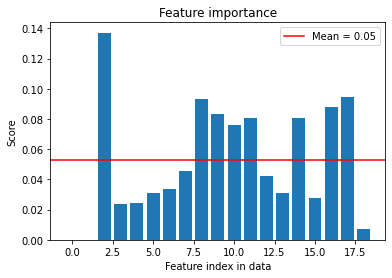

In [518]:
### using random forest to determine the relative feature importance

mess_importance_arr = RF_find_features(mess_df)

# plots the feature importance
plot_feature_importance(mess_importance_arr)

In [519]:
### finding the top 2 most important features to check values in correlation dataframe

top_2_features(mess_importance_arr, mess_df)

The most important feature is MA DETECTION CL 0.5
The second most important feature is OPTIC DISC DIAMATER


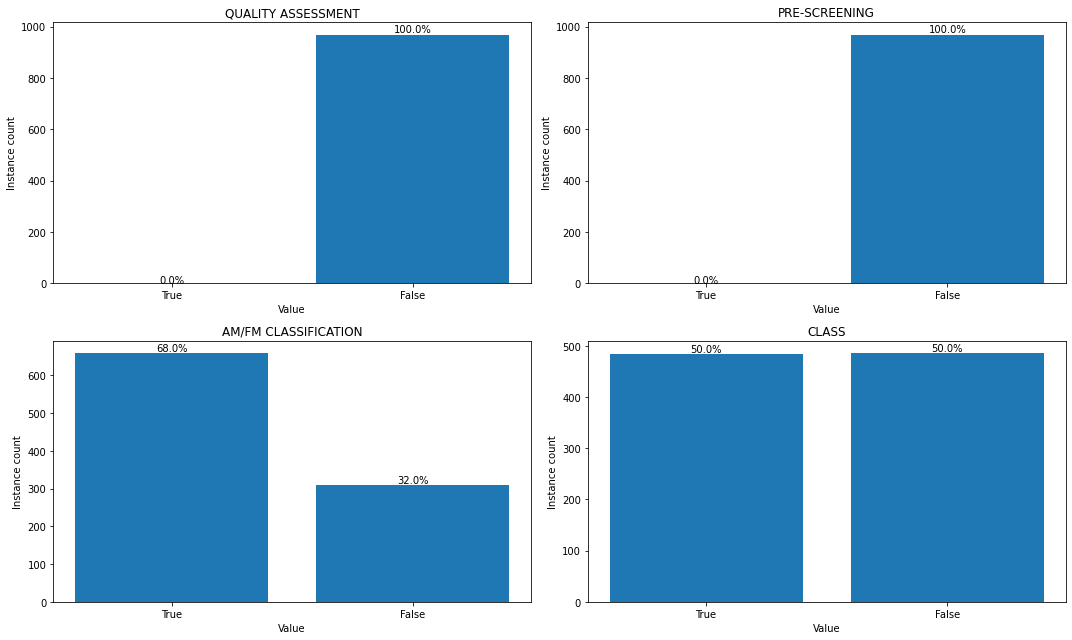

In [520]:
#### plotting a bar graph for each boolean column
plot_bool_distributions(mess_bool_cols, mess_df, 2)

# Implementing models

## Helper functions

In [521]:
### accuracy-evaluating function
def evaluate_acc(true_labels, target_labels):

  # the number of labels
  label_count = true_labels.shape[0]

  # the accuracy is the number of correctly labelled instances
  # divided by the total amount
  accuracy = np.sum(target_labels == true_labels)/label_count

  return accuracy

In [522]:

def plot_KNN(knn_model, class_pred, x_train, x_test, y_train, y_test, feature_names, fileName = ''):
    correct_pred = class_pred == y_test
    incorrect_pred = np.logical_not(correct_pred)

    _, knn_arr = knn_model.predict(x_test)

    # plots the data in a scatter plot
    plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, marker = 'o', alpha = 0.2, label = 'train')
    plt.scatter(x_test[correct_pred, 0], x_test[correct_pred, 1], marker = '.', c = class_pred[correct_pred], label = 'correct')
    plt.scatter(x_test[incorrect_pred, 0], x_test[incorrect_pred, 1], marker = 'x', c = class_pred[incorrect_pred], label = 'misclassified')

    # creates lines from data points to nearest neighbours
    for i in range(x_test.shape[0]):
      for k in range(knn_model.K):
        hor = x_test[i, 0], x_train[knn_arr[i, k], 0]
        ver = x_test[i, 1], x_train[knn_arr[i, k], 1]
        plt.plot(hor, ver, 'k-', alpha = 0.1)

    # labels the scatter plot accordingly and displays it
    if(feature_names == 0):
      plt.xlabel("Feature 1")
      plt.ylabel("Feature 2")
    else:
      plt.xlabel(feature_names[0])
      plt.ylabel(feature_names[1])

    plt.legend()

    if len(fileName) != 0:
      plt.savefig('images/' + fileName + '.png',dpi=300, bbox_inches='tight')
   
    plt.show()

def run_KNN(x_train, x_test, y_train, y_test, feature_names = 0, K_val = 3, function = 0, silent = False, fileName =''):

  fileName = fileName

  if function == 0:
    # creates a new KNN model
    knn_model = KNN(K = K_val)
  elif function in [euclidean, manhattan, cosine]:
    # creates a new KNN model
    knn_model = KNN(K = K_val, dist_fn = function)
  else:
    return

  # fits the model to the training data
  knn_model = knn_model.fit(x_train, y_train)

  # tests the model on the testing data and the training data
  class_prob, knn_arr = knn_model.predict(x_test)
  train_class_prob, _ = knn_model.predict(x_train) #

  # creates arrays of the most likely class labels for each instance
  class_pred = np.argmax(class_prob, axis = -1)
  train_pred = np.argmax(train_class_prob, axis = -1) #

  # finds the accuracy of the model
  accuracy = evaluate_acc(y_test, class_pred)
  train_accuracy = evaluate_acc(y_train, train_pred) #

  # creates boolean arrays to represent correct and incorrect predictions
  correct_pred = class_pred == y_test
  incorrect_pred = np.logical_not(correct_pred)

  if not silent:
    print("The accuracy of the model on the training data: " + str(round((train_accuracy * 100), 2)) + "%") #
    print("The accuracy of the model on the testing data: " + str(round((accuracy * 100), 2)) + "%")

  # if the data is based on two features
  if x_train.shape[1] == 2:
    plot_KNN(knn_model, class_pred, x_train, x_test, y_train, y_test, feature_names,fileName)
    

  return accuracy

In [523]:
def plot_DT(x, y, x_train, x_test, y_train, y_test, feature_names = 0,fileName=''):

  fileName = fileName

  #we can make the grid finer by increasing the number of samples from 200 to higher value
  x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
  x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

  # to features values as a mesh  
  x0, x1 = np.meshgrid(x0v, x1v)
  x_all = np.vstack((x0.ravel(),x1.ravel())).T

  #Number of classes:
  C = np.max(y)+1

  # Getting coloring for y
  y_train_prob = np.zeros((y_train.shape[0], C))
  y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

  model = DecisionTree(max_depth = 10, cost_fn = gini_cost)

  y_prob_all = model.fit(x_train, y_train).predict(x_all)
  y_pred_all = np.argmax(y_prob_all, axis = -1)

  # graphing the results
  plt.scatter(x_train[:,0], x_train[:,1], c = y_train, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c = y_pred_all, marker='.', alpha=.01)

  if(feature_names == 0):
      plt.xlabel("Feature 1")
      plt.ylabel("Feature 2")
  else:
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
  plt.savefig('images/' + fileName + '.png',dpi=300, bbox_inches='tight')
  plt.show()

def run_DT(x_train, x_test, y_train, y_test, x = [], y = [], feature_names = 0, depth = 3, function = 0, silent = False, fileName=''):
  fileName = fileName
  if function == 0:
    # creates a new DT Model
    dt_model = DecisionTree(max_depth = depth)
  elif function in [misclassification_cost, gini_cost, entropy_cost]:
    # creates a new DT Model
    dt_model = DecisionTree(max_depth = depth, cost_fn = function)
  else:
    return

  # fits the model to the training data
  dt_model = dt_model.fit(x_train, y_train)

  # tests the model on the testing data and the training data
  class_prob = dt_model.predict(x_test)

  # creates arrays of the most likely class labels for each instance
  class_pred = np.argmax(class_prob, axis = -1)

  # finds the accuracy of the model
  accuracy = evaluate_acc(y_test, class_pred)

  if not silent:
    print("The accuracy of the model is " + str(round((accuracy * 100), 2)) + "%")

  if x_train.shape[1] == 2 and len(x) != 0 and len(y) != 0:
    plot_DT(x, y, x_train, x_test, y_train, y_test, feature_names, fileName)

  return accuracy

## KNN

In [524]:
# distance functions
euclidean = lambda x_train, x_test: np.sqrt(np.sum((x_train - x_test)**2, axis = -1))
manhattan = lambda x_train, x_test: np.sum(np.abs(x_train - x_test), axis = -1)
cosine = lambda x_train, x_test: np.sum(x_train * x_test, axis = -1) / ((np.sqrt(np.sum(x_train**2, axis = -1))) *(np.sqrt(np.sum(x_test**2, axis = -1))))

class KNN:
  # constructor
  def __init__(self, K = 1, dist_fn = euclidean):
    self.dist_fn = dist_fn
    self.K = K

  def fit(self, x_train, y_train):
    # stores the training data, since KNN is a lazy learner
    self.x_train = x_train
    self.y_train = y_train

    # the number of classes
    self.class_count = len(set(y_train))
    return self

  def predict(self, x_test):
    # uses the stored training data and x_test (test data passed as input)

    # the number of instances in the testing data
    instance_count = x_test.shape[0]

    # an array of the distances between the training data points and the testing
    # data points
    distances_arr = self.dist_fn(self.x_train[None, :, :], x_test[:, None, :])
    
    # initializes an array full of zeros for the k-nearest neighbours
    knn_arr = np.zeros((instance_count, self.K), dtype = int)
    # initializes an array full of zeros for the class probabilities
    class_prob = np.zeros((instance_count, self.class_count))

    # iterates through each instance in the testing data
    for instance in range(instance_count):
      # the i-th index is an array with the k-nearest neighbours in x_train to
      # data point i in x_test
      knn_arr[instance, :] = np.argsort(distances_arr[instance])[:self.K]
      
      # the i-th index is an array counting the occurrence of each
      # class type for data point i in x_test where the j-th index of the 
      # sub-array represents the number of neighbours in x_train of class j
      class_prob[instance, :] = np.bincount(self.y_train[knn_arr[instance,:]], minlength = self.class_count)
      #print(self.y_train[knn_arr[instance, :]].dtype)

    # divides all probabilities by the number of neighbours to look for
    class_prob /= self.K

    return class_prob, knn_arr


## Decision Tree

In [525]:
### cost functions

def misclassification_cost(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

def entropy_cost(labels):
  cost = 0
  unique_labels = set(labels)
  label_count = len(labels)

  for unique_label in unique_labels:
    cur_labels = sum(1 for label in labels if label == unique_label)
    ratio = cur_labels / label_count
    cost += ratio * np.log2(ratio)

  cost *= -1
  return cost

def gini_cost(labels):
  cost = 0
  unique_labels = set(labels)
  label_count = len(labels)

  for unique_label in unique_labels:
    cur_labels = sum(1 for label in labels if label == unique_label)
    ratio = cur_labels / label_count
    cost += np.square(ratio)

  cost = 1 - cost
  return cost         

In [526]:
##This implementation is derrived from code found in DecisionTree.ipynb from the class's GitHub 

class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the indices of the data in the region of this node
        self.left = None                                    #stores the left child of this node 
        self.right = None                                   #stores the right child of this node

        #Splitting parameters
        self.split_feature = None                           #the feature being split at this node (data[f])
        self.split_value = None                             #the value that splits the data at this node. (data[f] <= value)

        #data passed from the parent
        if parent:
            self.depth = parent.depth + 1                   #this node's depth is 1 more than the parent's 
            self.num_classes = parent.num_classes           #copies the num classes from the parent which will be the same for all nodes
            self.data = parent.data                         #copies the data from the parent 
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes

In [527]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values (at the start there aren't any)
    min_cost = np.inf 
    best_feature, best_value = None, None

    num_instances, num_features = node.data.shape #the number of instances is equal to the number of rows in the data, #features is equal to the # columns

    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2. #gives each combination of left and right segments of the sorted data
    #ex: i = [1,2,3,4,5], test_cand = [1.5, 2.5, 3.5, 4.5]

    for d in range(num_features):
      #stores the data corresponding to the d-th feature
      data_d = node.data[node.data_indices, d]

      for val in test_candidates[:, d]: #for each value of a given feature
        #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_d <= val]
            right_indices = node.data_indices[data_d > val]

            #we can't have a split where a child has zero element (it would pretty much result in the same node again)
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue

            left_cost = cost_fn(node.labels[left_indices]) #calculate cost for the left side
            right_cost = cost_fn(node.labels[right_indices]) #calculate cost for the right side


            num_left, num_right = left_indices.shape[0], right_indices.shape[0] # weighted cost = cost * numElements / totalnumElements
            #get the combined cost using the weighted sum of left and right cost for the cuurent test value and feature
            cost = (num_left * left_cost + num_right * right_cost)/num_instances 
            
            #update only when a lower cost is encountered
            if cost < min_cost:
                min_cost = cost
                best_feature = d
                best_value = val
                
    return min_cost, best_feature, best_value

In [528]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=misclassification_cost, min_leaf_instances=1):
      self.max_depth = max_depth      #maximum dept for termination 
      self.root = None                #stores the root of the decision tree 
      self.cost_fn = cost_fn          #stores the cost function of the decision tree 
      self.num_classes = num_classes  #stores the total number of classes
      self.min_leaf_instances = min_leaf_instances  #minimum number of inst

    def fit(self, data, labels):
      self.data = data
      self.labels = labels
      if self.num_classes is None:
        self.num_classes = np.max(labels) + 1 #assumes the labels start at 0

        #below are initialization of the root of the decision tree
      self.root = Node(np.arange(data.shape[0]), None) #root should include all data indices and should not have a parent
      self.root.data = data
      self.root.labels = labels
      self.root.num_classes = self.num_classes
      self.root.depth = 0
      #to recursively build the rest of the tree
      self._fit_tree(self.root)
      return self

    def _fit_tree(self, node):

      #This gives the condition for termination of the recursion resulting in a leaf node
      if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
        #greedily select the best test by minimizing the cost
      cost, split_feature, split_value = greedy_test(node, self.cost_fn)

          #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
      if np.isinf(cost):
        return

      #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
      test = node.data[node.data_indices,split_feature] <= split_value
          #store the split feature and value of the node
      node.split_feature = split_feature
      node.split_value = split_value
          #define new nodes which are going to be the left and right child of the present node
      left = Node(node.data_indices[test], node)
      right = Node(node.data_indices[np.logical_not(test)], node)
          #recursive call to the _fit_tree()
      self._fit_tree(left)
      self._fit_tree(right)
          #assign the left and right child to present child    
      node.left = left
      node.right = right

    def predict(self, data_test):
      class_probs = np.zeros((data_test.shape[0], self.num_classes))
      for n, x in enumerate(data_test):
          node = self.root
          #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
          while node.left:
              if x[node.split_feature] <= node.split_value:
                  node = node.left
              else:
                  node = node.right
          #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
          class_probs[n,:] = node.class_prob
      return class_probs

# Running experiments

### Helper functions

In [529]:
def test_diff_K(x, y, fileName = ''):
  # splitting the data into training, validation, and testing
  #x_train_temp, x_test, y_train_temp, y_test = train_test_split2(x, y)
  #x_train, x_valid, y_train, y_valid = train_test_split2(x_train_temp, y_train_temp)

  fileName = fileName

  x_train_temp, x_test, y_train_temp, y_test = skl_train_test_split(x, y, test_size = 0.2, random_state = 11)
  x_train, x_valid, y_train, y_valid = skl_train_test_split(x_train_temp, y_train_temp, test_size = 0.2, random_state = 11)

  # choice of K
  model_choices = []
  train_acc_arr = []
  valid_acc_arr = []

  n_train = y_train.shape[0]
  n_valid = y_valid.shape[0]

  # iterates through different K values
  for K_val in range(1, 15):
    # creates a new KNN object
    knn = KNN(K_val)

    # fits the model to the training data
    knn = knn.fit(x_train, y_train)

    # evaluates the accuracy of the model on the training data
    y_train_prob, _ = knn.predict(x_train)
    y_train_pred = np.argmax(y_train_prob, axis = -1)
    train_acc = evaluate_acc(y_train_pred, y_train)

    # evaluates the accuracy of the model on the validation data
    y_valid_prob, _ = knn.predict(x_valid)
    y_valid_pred = np.argmax(y_valid_prob, axis = -1)
    valid_acc = evaluate_acc(y_valid_pred, y_valid)

    # appends the current K value, training accuracy, and
    # validation accuracy
    model_choices.append(K_val)
    train_acc_arr.append(train_acc)
    valid_acc_arr.append(valid_acc)

  # uses the best K to predict the test data
  best_valid_acc = max(valid_acc_arr)
  best_valid_acc_index = valid_acc_arr.index(best_valid_acc)
  best_k = model_choices[best_valid_acc_index]

  #knn = KNN(best_k)
  #y_test_prob, _ = knn.fit(x_train, y_train).predict(x_test)
  #y_test_pred = np.argmax(y_test_prob, axis = -1)
  #accuracy = np.sum(y_test_pred == y_test) / y_test.shape[0]
  accuracy = run_KNN(x_train, x_test, y_train, y_test, K_val = best_k, fileName = fileName)

  print("")
  print("Best depth = " + str(best_k))
  print("")
  
  plt.plot(model_choices, train_acc_arr, marker='d', color='black', label='training')
  plt.plot(model_choices, valid_acc_arr, marker='o', color='blue', label='validation')
  plt.plot(best_k, accuracy, marker='*', color='red', label='testing')
  plt.xlabel("K")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.savefig('images/' + fileName + '.png',dpi=300, bbox_inches='tight')
 


## KNN experiments

In [530]:
### running KNN on all hep_df data
acc = run_KNN(x_train_hep, x_test_hep, y_train_hep, y_test_hep)

The accuracy of the model on the training data: 85.42%
The accuracy of the model on the testing data: 88.46%


In [531]:
### running KNN on all normalized hep_df data

# splitting the normalized hep_df data
x_train_hep_n, x_test_hep_n, y_train_hep_n, y_test_hep_n = train_test_split(normalize_df(hep_df))

acc = run_KNN(x_train_hep_n, x_test_hep_n, y_train_hep_n, y_test_hep_n)

The accuracy of the model on the training data: 89.58%
The accuracy of the model on the testing data: 92.31%


In [532]:
### running KNN on all standardized hep_df data

# splitting the standardized hep_df data
x_train_hep_s, x_test_hep_s, y_train_hep_s, y_test_hep_s = train_test_split(standardize_df(hep_df))

acc = run_KNN(x_train_hep_s, x_test_hep_s, y_train_hep_s, y_test_hep_s)

The accuracy of the model on the training data: 89.58%
The accuracy of the model on the testing data: 88.46%


In [533]:
### running KNN on all hep_df data cleaned through imputation

acc = run_KNN(x_train_hep_imp, x_test_hep_imp, y_train_hep_imp, y_test_hep_imp)

The accuracy of the model on the training data: 85.29%
The accuracy of the model on the testing data: 73.58%


The accuracy of the model on the training data: 85.42%
The accuracy of the model on the testing data: 92.31%


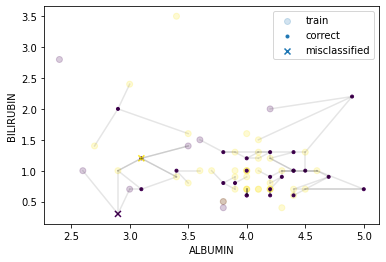

In [534]:
### running KNN on hep_df for top 2 features

# splits the hep_df dataframe to only include the columns with the top 2
# features and the target labels
hep_df2 = hep_df[['ALBUMIN', 'BILIRUBIN', 'CLASS']]

# runs train_test_split on the new dataframe
x_train_hep2, x_test_hep2, y_train_hep2, y_test_hep2 = train_test_split(hep_df2)

# runs KNN
fileName = 'run_KNN1'
acc = run_KNN(x_train_hep2, x_test_hep2, y_train_hep2, y_test_hep2, ['ALBUMIN', 'BILIRUBIN'],fileName = fileName)

In [535]:
### running KNN on mess_df data
acc = run_KNN(x_train_mess, x_test_mess, y_train_mess, y_test_mess)

The accuracy of the model on the training data: 82.45%
The accuracy of the model on the testing data: 62.73%


The accuracy of the model on the training data: 76.33%
The accuracy of the model on the testing data: 57.27%


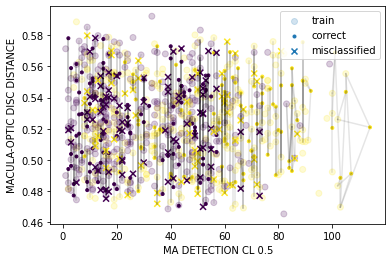

In [536]:
### running KNN on mess_df data for top 2 important features

# splits the hep_df dataframe to only include the columns with the top 2
# features and the target labels
mess_df2 = mess_df[['MA DETECTION CL 0.5', 'MACULA-OPTIC DISC DISTANCE', 'CLASS']]

# runs train_test_split on the new dataframe
x_train_mess2, x_test_mess2, y_train_mess2, y_test_mess2 = train_test_split(mess_df2)

# runs KNN
fileName = 'run_KNN2'
acc = run_KNN(x_train_mess2, x_test_mess2, y_train_mess2, y_test_mess2, ['MA DETECTION CL 0.5', 'MACULA-OPTIC DISC DISTANCE'], fileName = fileName)

The accuracy of the model on the training data: 80.56%
The accuracy of the model on the testing data: 52.12%


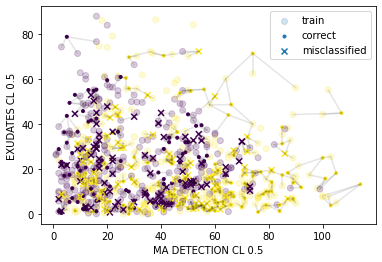

In [537]:
### running KNN on mess_df data for top 2 correlated features

# splits the hep_df dataframe to only include the columns with the top 2 correlated
# features and the target labels
mess_df2c = mess_df[['MA DETECTION CL 0.5', 'EXUDATES CL 0.5', 'CLASS']]

# runs train_test_split on the new dataframe
x_train_mess2c, x_test_mess2c, y_train_mess2c, y_test_mess2c = train_test_split(mess_df2c)

# runs KNN
fileName='run_KNN3'
acc = run_KNN(x_train_mess2c, x_test_mess2c, y_train_mess2c, y_test_mess2c, ['MA DETECTION CL 0.5', 'EXUDATES CL 0.5'],fileName = fileName)

### Testing different values for K

The accuracy of the model on the training data: 91.49%
The accuracy of the model on the testing data: 86.67%

Best depth = 5



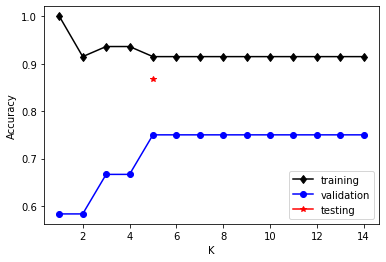

In [538]:
x = hep_df.iloc[:, :-1].to_numpy()
y = hep_df.iloc[:, -1].to_numpy()
fileName = 'test_diff_K1'
test = test_diff_K(x, y, fileName)

The accuracy of the model on the training data: 70.76%
The accuracy of the model on the testing data: 68.04%

Best depth = 12



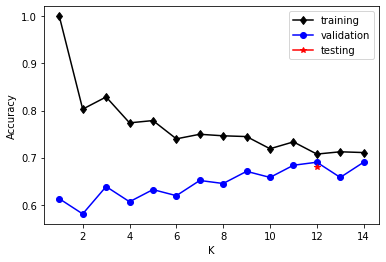

In [539]:
x = mess_df.iloc[:, :-1].to_numpy()
y = mess_df.iloc[:, -1].to_numpy()
fileName = 'test_diff_K2'
test = test_diff_K(x, y,fileName)

### Using different distance functions

In [540]:
# functions = array of function objects
# function_strings = array of the function names as strings
# k_values = array of k values
def test_distances(functions, function_strings, k_values, x_train, x_test, y_train, y_test):
  for index in range(len(functions)):
    d_function = functions[index]
    function_string = function_strings[index]
    print("Testing " + function_string + " distance function:")

    for k in k_values:
      accuracy = run_KNN(x_train, x_test, y_train, y_test, K_val = k, function = d_function, silent = True)

      print("\tk = " + str(k))
      print("\tModel accuracy: " + str(round(accuracy, 2)) + "%")
      print("")

In [541]:
### on hep_df

functions = [euclidean, manhattan, cosine]
function_strings = ['euclidean', 'manhattan', 'cosine']
k_values = [1, 3, 5]

test_distances(functions, function_strings, k_values, x_train_hep, x_test_hep, y_train_hep, y_test_hep)

Testing euclidean distance function:
	k = 1
	Model accuracy: 0.85%

	k = 3
	Model accuracy: 0.88%

	k = 5
	Model accuracy: 0.92%

Testing manhattan distance function:
	k = 1
	Model accuracy: 0.85%

	k = 3
	Model accuracy: 0.88%

	k = 5
	Model accuracy: 0.88%

Testing cosine distance function:
	k = 1
	Model accuracy: 0.85%

	k = 3
	Model accuracy: 0.77%

	k = 5
	Model accuracy: 0.96%



In [542]:
### on mess_df

functions = [euclidean, manhattan, cosine]
function_strings = ['euclidean', 'manhattan', 'cosine']
k_values = [1, 3, 5]

test_distances(functions, function_strings, k_values, x_train_mess, x_test_mess, y_train_mess, y_test_mess)

Testing euclidean distance function:
	k = 1
	Model accuracy: 0.6%

	k = 3
	Model accuracy: 0.63%

	k = 5
	Model accuracy: 0.65%

Testing manhattan distance function:
	k = 1
	Model accuracy: 0.61%

	k = 3
	Model accuracy: 0.64%

	k = 5
	Model accuracy: 0.64%

Testing cosine distance function:
	k = 1
	Model accuracy: 0.49%

	k = 3
	Model accuracy: 0.47%

	k = 5
	Model accuracy: 0.46%



### Feature Importance

For feature importance we will employ a simple approach. We will first train a model using a training set. We will then use that model predict the labels of the training set. Afterwards we can fit a random forest (could be linear regression as well) model on the training input and the predicted output. From there we can extract the importances of this new model to see how the original model weighs the importance of each individual to make its prediction.
Essentially
$$knn.fit(x_{train}, y_{train}).predict(x_{train}) = \hat y, \space importance = RandomForest.fit(x_{train}, \hat y).featureImportances$$

In [543]:
# we use k!=1, otherwise y_pred = y
def knn_feat_importance(x_train, y_train, df):
  knn_model = KNN(3)
  knn_model = knn_model.fit(x_train, y_train)

  class_prob, _ = knn_model.predict(x_train)
  class_pred = np.argmax(class_prob, axis = -1)

  feat_arr = RF_find_features_XY(x_train, class_pred, df)

In [544]:
# hep

knn_feat_importance(x_train_hep, y_train_hep, hep_df)

Feature: AGE, Score: 0.06774
Feature: SEX, Score: 0.00356
Feature: STEROID, Score: 0.00223
Feature: ANTIVIRALS, Score: 0.00670
Feature: FATIGUE, Score: 0.00000
Feature: MALAISE, Score: 0.00000
Feature: ANOREXIA, Score: 0.05892
Feature: LIVER BIG, Score: 0.00000
Feature: LIVER FIRM, Score: 0.00709
Feature: SPLEEN PALPABLE, Score: 0.02486
Feature: SPIDERS, Score: 0.00355
Feature: ASCITES, Score: 0.01233
Feature: VARICES, Score: 0.00416
Feature: BILIRUBIN, Score: 0.04986
Feature: ALK PHOSPHATE, Score: 0.02896
Feature: SGOT, Score: 0.04645
Feature: ALBUMIN, Score: 0.15996
Feature: PROTIME, Score: 0.51993
Feature: HISTOLOGY, Score: 0.00369


In [545]:
# messidor

knn_feat_importance(x_train_mess, y_train_mess, mess_df)

Feature: QUALITY ASSESSMENT, Score: 0.00000
Feature: PRE-SCREENING, Score: 0.00000
Feature: MA DETECTION CL 0.5, Score: 0.18422
Feature: MA DETECTION CL 0.58, Score: 0.02880
Feature: MA DETECTION CL 0.66, Score: 0.02377
Feature: MA DETECTION CL 0.75, Score: 0.03184
Feature: MA DETECTION CL 0.83, Score: 0.03118
Feature: MA DETECTION CL 0.91, Score: 0.05516
Feature: MA DETECTION CL 1.0, Score: 0.13927
Feature: EXUDATES CL 0.5, Score: 0.10261
Feature: EXUDATES CL 0.58, Score: 0.06662
Feature: EXUDATES CL 0.66, Score: 0.05197
Feature: EXUDATES CL 0.75, Score: 0.02662
Feature: EXUDATES CL 0.83, Score: 0.02251
Feature: EXUDATES CL 0.91, Score: 0.05865
Feature: EXUDATES CL 1.0, Score: 0.01917
Feature: MACULA-OPTIC DISC DISTANCE, Score: 0.07280
Feature: OPTIC DISC DIAMATER, Score: 0.07952
Feature: AM/FM CLASSIFICATION, Score: 0.00530


## DT experiments

In [546]:
### running DT on all hep_df data
acc = run_DT(x_train_hep, x_test_hep, y_train_hep, y_test_hep, hep_df)

The accuracy of the model is 88.46%


In [547]:
### running KNN on all normalized hep_df data
acc = run_DT(x_train_hep_n, x_test_hep_n, y_train_hep_n, y_test_hep_n)

The accuracy of the model is 88.46%


In [548]:
### running KNN on all standardized hep_df data
acc = run_DT(x_train_hep_s, x_test_hep_s, y_train_hep_s, y_test_hep_s)

The accuracy of the model is 88.46%


In [549]:
### running DT on all hep_df data cleaned through imputation
acc = run_DT(x_train_hep_imp, x_test_hep_imp, y_train_hep_imp, y_test_hep_imp, hep_imp_df)

The accuracy of the model is 83.02%


The accuracy of the model is 96.15%


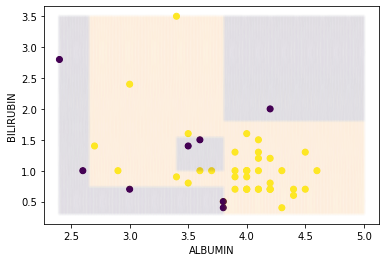

In [550]:
### running DT on hep_df for top 2 features
x_all = hep_df2.iloc[:, :-1].to_numpy()
y_all = hep_df2.iloc[:, -1].to_numpy()
fileName = 'run_DT1'
acc = run_DT(x_train_hep2, x_test_hep2, y_train_hep2, y_test_hep2, x = x_all, y = y_all, feature_names = ['ALBUMIN', 'BILIRUBIN'], fileName = fileName)

In [551]:
### running DT on mess_df data
acc = run_DT(x_train_mess, x_test_mess, y_train_mess, y_test_mess)

The accuracy of the model is 62.42%


The accuracy of the model is 58.79%


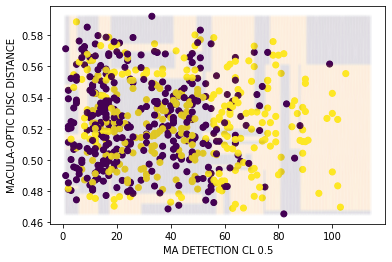

In [552]:
### running DT on mess_df data for top 2 important features

x_all = mess_df2.iloc[:, :-1].to_numpy()
y_all = mess_df2.iloc[:, -1].to_numpy()

# runs DT
fileName = 'run_DT2'
acc = run_DT(x_train_mess2, x_test_mess2, y_train_mess2, y_test_mess2, x = x_all, y = y_all, feature_names = ['MA DETECTION CL 0.5', 'MACULA-OPTIC DISC DISTANCE'], fileName = fileName)

The accuracy of the model is 60.91%


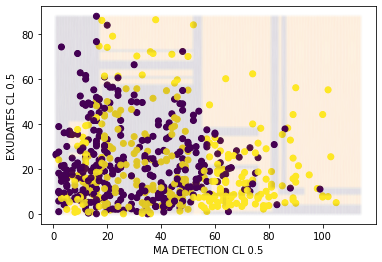

In [553]:
### running DT on mess_df data for top 2 important features

x_all = mess_df2c.iloc[:, :-1].to_numpy()
y_all = mess_df2c.iloc[:, -1].to_numpy()

# runs DT
fileName = 'run_DT3'
acc = run_DT(x_train_mess2c, x_test_mess2c, y_train_mess2c, y_test_mess2c, x = x_all, y = y_all, feature_names = ['MA DETECTION CL 0.5', 'EXUDATES CL 0.5'], fileName = fileName)

### Using different cost functions

In [554]:
# HERE GARY

### Feature Importance

For feature importance we will employ a simple approach. We will first train a model using a training set. We will then use that model predict the labels of the training set. Afterwards we can fit a random forest (could be linear regression as well) model on the training input and the predicted output. From there we can extract the importances of this new model to see how the original model weighs the importance of each individual to make its prediction.
Essentially
$$dt.fit(x_{train}, y_{train}).predict(x_{train}) = \hat y, \space importance = RandomForest.fit(x_{train}, \hat y).featureImportances$$

In [555]:
def dt_feat_importance(x_train, y_train, df):
  dt_model = DecisionTree(max_depth = 10, cost_fn = gini_cost)
  dt_model = dt_model.fit(x_train, y_train)

  class_prob = dt_model.predict(x_train)
  class_pred = np.argmax(class_prob, axis = -1)

  feat_arr = RF_find_features_XY(x_train, class_pred, df)

In [556]:
# hep_df

dt_feat_importance(x_train_hep, y_train_hep, hep_df)

Feature: AGE, Score: 0.05453
Feature: SEX, Score: 0.01343
Feature: STEROID, Score: 0.00147
Feature: ANTIVIRALS, Score: 0.00000
Feature: FATIGUE, Score: 0.00324
Feature: MALAISE, Score: 0.00509
Feature: ANOREXIA, Score: 0.02029
Feature: LIVER BIG, Score: 0.00870
Feature: LIVER FIRM, Score: 0.00320
Feature: SPLEEN PALPABLE, Score: 0.00643
Feature: SPIDERS, Score: 0.01683
Feature: ASCITES, Score: 0.02282
Feature: VARICES, Score: 0.01316
Feature: BILIRUBIN, Score: 0.13243
Feature: ALK PHOSPHATE, Score: 0.11435
Feature: SGOT, Score: 0.05175
Feature: ALBUMIN, Score: 0.10389
Feature: PROTIME, Score: 0.32328
Feature: HISTOLOGY, Score: 0.10511


In [557]:
# mess_df

dt_feat_importance(x_train_mess, y_train_mess, mess_df)

Feature: QUALITY ASSESSMENT, Score: 0.00000
Feature: PRE-SCREENING, Score: 0.00000
Feature: MA DETECTION CL 0.5, Score: 0.20047
Feature: MA DETECTION CL 0.58, Score: 0.02701
Feature: MA DETECTION CL 0.66, Score: 0.02046
Feature: MA DETECTION CL 0.75, Score: 0.02812
Feature: MA DETECTION CL 0.83, Score: 0.03726
Feature: MA DETECTION CL 0.91, Score: 0.04041
Feature: MA DETECTION CL 1.0, Score: 0.09678
Feature: EXUDATES CL 0.5, Score: 0.08344
Feature: EXUDATES CL 0.58, Score: 0.06002
Feature: EXUDATES CL 0.66, Score: 0.06854
Feature: EXUDATES CL 0.75, Score: 0.03317
Feature: EXUDATES CL 0.83, Score: 0.02383
Feature: EXUDATES CL 0.91, Score: 0.10270
Feature: EXUDATES CL 1.0, Score: 0.01842
Feature: MACULA-OPTIC DISC DISTANCE, Score: 0.07598
Feature: OPTIC DISC DIAMATER, Score: 0.07976
Feature: AM/FM CLASSIFICATION, Score: 0.00360
